In [ ]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
from google.colab import drive
drive.mount('/content/drive')

!unzip /content/drive/MyDrive/smai_project/images_train.zip
!unzip /content/drive/MyDrive/smai_project/images_val.zip

Streaming output truncated to the last 5000 lines.
  inflating: __MACOSX/images_train/._img_2493.jpg  
  inflating: images_train/img_3955.jpg  
  inflating: __MACOSX/images_train/._img_3955.jpg  
  inflating: images_train/img_6193.jpg  
  inflating: __MACOSX/images_train/._img_6193.jpg  
  inflating: images_train/img_4974.jpg  
  inflating: __MACOSX/images_train/._img_4974.jpg  
  inflating: images_train/img_3630.jpeg  
  inflating: __MACOSX/images_train/._img_3630.jpeg  
  inflating: images_train/img_3969.jpg  
  inflating: __MACOSX/images_train/._img_3969.jpg  
  inflating: images_train/img_3260.jpeg  
  inflating: __MACOSX/images_train/._img_3260.jpeg  
  inflating: images_train/img_4960.jpg  
  inflating: __MACOSX/images_train/._img_4960.jpg  
  inflating: images_train/img_4771.jpeg  
  inflating: __MACOSX/images_train/._img_4771.jpeg  
  inflating: images_train/img_3558.jpg  
  inflating: __MACOSX/images_train/._img_3558.jpg  
  inflating: images_train/img_4237.jpg  
  inflating: 

trying new

In [ ]:
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(256, scale=(0.7,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.2,0.2,0.2,0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

remove = {95, 145, 146, 158, 159, 160, 161}
scaler = StandardScaler()

def inverse_transform_coords(coords_tensor):
  coords_np = coords_tensor.detach().cpu().numpy()
  return scaler.inverse_transform(coords_np)

def compute_real_world_mse(pred_coords, true_coords):
  return mean_squared_error(true_coords, pred_coords)

def clean_dataframe(df):
    df = df[(df['longitude'] >= 100000) & (df['longitude'] <= 700000)]
    df = df[(df['latitude'] >= 50000) & (df['latitude'] <= 250000)]
    return df.reset_index(drop=True)

class ImageDataset(Dataset):
    def __init__(self, csv_file, images_dir, transform=None, val=False, mse=False, apply_cleaning=True):
        self.df = pd.read_csv(csv_file)

        if apply_cleaning:
            self.df = clean_dataframe(self.df)

        if mse:
            self.df = self.df[~self.df.index.isin(remove)].reset_index(drop=True)

        self.images_dir = images_dir
        self.transform = transform

        coords = self.df[['latitude', 'longitude']].values
        self.scaled_coords = scaler.fit_transform(coords) if not val else scaler.transform(coords)

        if not val:
            self.plot_scaled_coordinates()

    def plot_scaled_coordinates(self):
        latitudes = self.scaled_coords[:, 0]
        longitudes = self.scaled_coords[:, 1]

        plt.figure(figsize=(10, 6))
        plt.scatter(longitudes, latitudes, c='blue', alpha=0.5)
        plt.title("Scaled Latitude vs Longitude")
        plt.xlabel("Longitude")
        plt.ylabel("Latitude")
        plt.show()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.images_dir, row['filename'])
        img = Image.open(img_path).convert('RGB')
        if img.size != (256, 256):
            img = img.resize((256, 256), Image.BILINEAR)
        img = self.transform(img)

        coords = torch.tensor(self.scaled_coords[idx], dtype=torch.float32)
        angle = torch.tensor(row['angle'], dtype=torch.float32)
        region = torch.tensor(row['Region_ID'] - 1, dtype=torch.long)

        return img, region, coords, angle

train_data = ImageDataset("/content/drive/MyDrive/smai_project/labels_train_updated.csv",
                          "/content/images_train", transform=train_transform, mse=False)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

val_data = ImageDataset("/content/drive/MyDrive/smai_project/labels_val_updated.csv",
                        "/content/images_val", transform=val_transform, mse=True, apply_cleaning = False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

class MeanAngularError(nn.Module):
    def forward(self, y_pred, y_true):
        diff = torch.remainder(torch.abs(y_pred - y_true), 360)
        ang_err = torch.minimum(diff, 360 - diff)
        return torch.mean(ang_err)

class ImprovedResNet(nn.Module):
    def __init__(self):
        super().__init__()
        base = models.resnet50(pretrained=True)
        for name, p in base.named_parameters():
            if 'layer3' in name or 'layer4' in name or 'fc' in name:
                p.requires_grad = True
            else:
                p.requires_grad = False
        base.fc = nn.Identity()
        self.backbone = base
        self.dropout = nn.Dropout(0.5)
        self.region = nn.Linear(2048, 15)
        self.coord  = nn.Linear(2048, 2)
        self.coord_head = nn.Sequential(
            nn.Linear(2048, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 2)
        )
        self.angle  = nn.Linear(2048, 1)

        self.region_criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        self.coord_criterion  = nn.MSELoss()
        self.angle_criterion  = MeanAngularError()

    def forward(self, x):
        f = self.backbone(x).squeeze()
        f = self.dropout(f)
        return self.region(f), self.coord_head(f), self.angle(f).squeeze(1)

    def evaluate(self, val_loader, device):
        self.eval()
        correct, sum_ang_err = 0, 0
        all_preds = []
        all_targets = []

        with torch.no_grad():
            for imgs, regions, coords, angles in val_loader:
                imgs, regions, coords, angles = imgs.to(device), regions.to(device), coords.to(device), angles.to(device)
                pr, pc, pa = self(imgs)

                correct += (pr.argmax(dim=1) == regions).sum().item()
                sum_ang_err += self.angle_criterion(pa, angles).item() * imgs.size(0)

                all_preds.append(pc)
                all_targets.append(coords)

        all_preds = torch.cat(all_preds, dim=0)
        all_targets = torch.cat(all_targets, dim=0)

        preds_real = inverse_transform_coords(all_preds)
        targets_real = inverse_transform_coords(all_targets)

        lat_pred, lon_pred = preds_real[:, 0], preds_real[:, 1]
        lat_true, lon_true = targets_real[:, 0], targets_real[:, 1]

        lat_mse = mean_squared_error(lat_true, lat_pred)
        lon_mse = mean_squared_error(lon_true, lon_pred)
        avg_mse = 0.5 * (lat_mse + lon_mse)

        n = len(val_loader.dataset)
        print(f"Val Acc: {correct/n:.4f}, Coord Avg MSE (real scale): {avg_mse:.4f}, "
              f"(Lat MSE: {lat_mse:.4f}, Lon MSE: {lon_mse:.4f}), Mean Angular Error: {sum_ang_err/n:.4f}\n")


    def train_model(self, train_loader, val_loader, epochs=15, lr=1e-5, device='cuda'):
        self.to(device)
        opt = torch.optim.AdamW(self.parameters(), lr=lr, weight_decay=1e-4)
        sched = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs, eta_min=1e-6)

        for ep in range(1, epochs+1):
            self.train(); total=0
            for imgs, regs, coords, angs in train_loader:
                imgs, regs, coords, angs = [t.to(device) for t in (imgs, regs, coords, angs)]
                opt.zero_grad()
                pr, pc, pa = self(imgs)
                l = 2*self.region_criterion(pr, regs)
                l+= 0.5*self.coord_criterion(pc, coords)
                l+= 0.05*self.angle_criterion(pa, angs)
                l.backward(); opt.step()
                total+= l.item()*imgs.size(0)
            print(f"Epoch{ep} TrainLoss:{total/len(train_loader.dataset):.4f} LR:{sched.get_last_lr()[0]:.1e}")
            sched.step()
            self.evaluate(val_loader, device)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ImprovedResNet()
model.train_model(train_loader, val_loader, epochs=20, lr=1e-4, device=device)

transformer

new region id

In [8]:
!unzip /content/drive/MyDrive/smai_project/images_test.zip

Archive:  /content/drive/MyDrive/smai_project/images_test.zip
   creating: images_test/
  inflating: __MACOSX/._images_test  
  inflating: images_test/img_0000.jpg  
  inflating: __MACOSX/images_test/._img_0000.jpg  
  inflating: images_test/img_0028.jpg  
  inflating: __MACOSX/images_test/._img_0028.jpg  
  inflating: images_test/img_0216.jpg  
  inflating: __MACOSX/images_test/._img_0216.jpg  
  inflating: images_test/img_0062.JPEG  
  inflating: __MACOSX/images_test/._img_0062.JPEG  
  inflating: images_test/img_0362.jpg  
  inflating: __MACOSX/images_test/._img_0362.jpg  
  inflating: images_test/img_0131.jpeg  
  inflating: __MACOSX/images_test/._img_0131.jpeg  
  inflating: images_test/img_0160.jpg  
  inflating: __MACOSX/images_test/._img_0160.jpg  
  inflating: images_test/img_0174.jpg  
  inflating: __MACOSX/images_test/._img_0174.jpg  
  inflating: images_test/img_0148.jpg  
  inflating: __MACOSX/images_test/._img_0148.jpg  
  inflating: images_test/img_0149.jpg  
  inflating

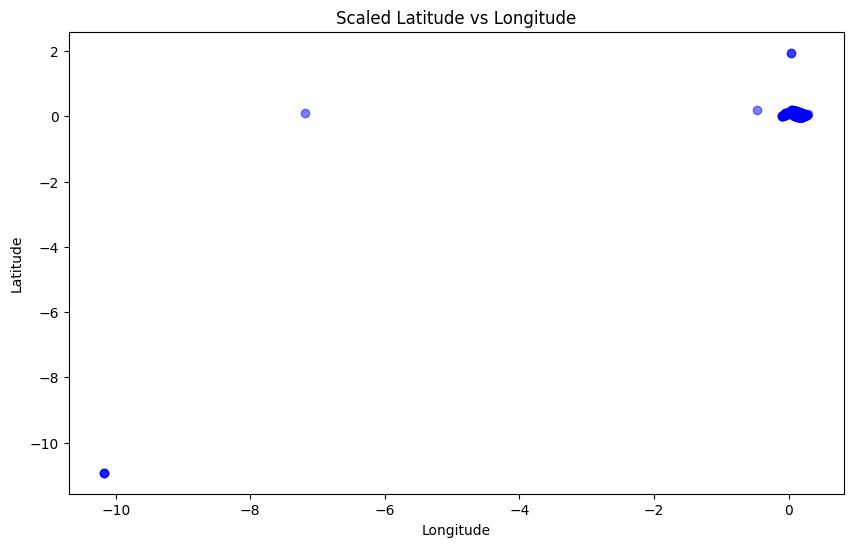

369
369
Submission file created successfully!


In [ ]:
import pandas as pd
import torch

model.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

predictions = []
val_data = ImageDataset("/content/drive/MyDrive/smai_project/labels_val_updated.csv",
                        "/content/images_val", transform=val_transform, mse=False, apply_cleaning = False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

with torch.no_grad():
    for imgs, regions, coords, angles in val_loader:
        imgs = imgs.to(device)
        pr, _, _ = model(imgs)
        preds = pr.argmax(dim=1).cpu().numpy()
        predictions.extend(preds)

predictions = [p + 1 for p in predictions]

class FolderImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_filenames = sorted(os.listdir(image_dir))  
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        img = Image.open(img_path).convert('RGB')
        if img.size != (256, 256):
            img = img.resize((256, 256), Image.BILINEAR)
        if self.transform:
            img = self.transform(img)
        return img

print(len(predictions))
transform = transforms.Compose([
      transforms.ToTensor(),
    ])
dataset = FolderImageDataset("/content/images_test", transform=transform)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

test_preds = []

model.eval()
with torch.no_grad():
    for imgs in test_loader:  
        imgs = imgs.to(device)
        pr, _, _ = model(imgs)
        preds = pr.argmax(dim=1).cpu().numpy()  
        test_preds.extend(preds)

test_preds = [p + 1 for p in test_preds]
print(len(test_preds))
submission_ids = list(range(738)) 
submission_regions = predictions + test_preds  

submission_df = pd.DataFrame({
    'id': submission_ids,
    'Region_ID': submission_regions
})

submission_df.to_csv('2021102007_4.csv', index=False)
print("Submission file created successfully!")